# COVID-19 Developments in Brazil

*Marianne Costa Avalone*

In [56]:
# Import libraries
import requests as r
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime, timezone
from prophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [48]:
# Request data from public API
url = 'https://api.covid19api.com/dayone/country/brazil'
req = r.get(url)

In [49]:
# Request status
req.status_code

200

In [50]:
# Save database
covid19 = req.json()
with open('covid19.json', 'w') as f:
    json.dump(covid19, f)

In [51]:
# Read database
covid19 = pd.read_json('covid19.json')
covid19.tail()

,ID,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
961,b83efadc-57d3-4a42-8041-caa5fa30210e,Brazil,BR,,,,-14.24,-51.93,34746462,687144,0,34059318,2022-10-14 00:00:00+00:00
962,8cb14751-466f-49e3-a872-c386a399acb4,Brazil,BR,,,,-14.24,-51.93,34746462,687144,0,34059318,2022-10-15 00:00:00+00:00
963,e1aab213-7000-4d66-a623-616d43480485,Brazil,BR,,,,-14.24,-51.93,34746462,687144,0,34059318,2022-10-16 00:00:00+00:00
964,1d77e687-2117-4942-beec-1f7658770a64,Brazil,BR,,,,-14.24,-51.93,34746462,687144,0,34059318,2022-10-17 00:00:00+00:00
965,1ac68a02-5cfb-4f8d-86ef-3a7c9f8a112c,Brazil,BR,,,,-14.24,-51.93,34746462,687144,0,34059318,2022-10-18 00:00:00+00:00


In [52]:
# Read database info
covid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   ID           966 non-null    object             
 1   Country      966 non-null    object             
 2   CountryCode  966 non-null    object             
 3   Province     966 non-null    object             
 4   City         966 non-null    object             
 5   CityCode     966 non-null    object             
 6   Lat          966 non-null    float64            
 7   Lon          966 non-null    float64            
 8   Confirmed    966 non-null    int64              
 9   Deaths       966 non-null    int64              
 10  Recovered    966 non-null    int64              
 11  Active       966 non-null    int64              
 12  Date         966 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(4), object(6)
memory usage: 98.2+ K

In [53]:
# Confirm redundant columns
print('Unique Countries: ', covid19.Country.unique())
print('Unique Country Codes: ', covid19.CountryCode.unique())
print('Unique Provinces: ', covid19.Province.unique())
print('Unique Cities: ', covid19.City.unique())
print('Unique City Codes: ', covid19.CityCode.unique())
print('Unique Latitudes: ', covid19.Lat.unique())
print('Unique Longitudes: ', covid19.Lon.unique())

Unique Countries:  ['Brazil']
Unique Country Codes:  ['BR']
Unique Provinces:  ['']
Unique Cities:  ['']
Unique City Codes:  ['']
Unique Latitudes:  [-14.24]
Unique Longitudes:  [-51.93]


## Cleaning up data

- Column 'ID' has entries for data computed in the API for several countries since the beggining of the pandemic. For this analysis, since the data requested from the API is solely from Brazil, we will prefer to use de column 'Date' for indexing the dataframe.
- Columns 'Country', 'CountryCode', 'Lat' and 'Lon' are redundant, because all data requested is from Brazil.
- Columns 'Province' and 'CityCode' are null and don't add specific information about the COVID-19 case locations.

In [54]:
# Drop unnecessary columns
covid19_df = covid19.drop(['ID', 'Country', 'CountryCode', 'Province', 'City', 'CityCode', 'Lat', 'Lon'], axis=1)
covid19_df.head()

,Confirmed,Deaths,Recovered,Active,Date
0,1,0,0,1,2020-02-26 00:00:00+00:00
1,1,0,0,1,2020-02-27 00:00:00+00:00
2,1,0,0,1,2020-02-28 00:00:00+00:00
3,2,0,0,2,2020-02-29 00:00:00+00:00
4,2,0,0,2,2020-03-01 00:00:00+00:00


- Timezone information wasn't computed in the global database for Brazil. Thus, we can remove timezone info from the column 'Date'

In [58]:
# Develop function to cleanup timezone info
covid19_df['Date'] = covid19_df['Date'].dt.tz_localize(None)
covid19_df

,Confirmed,Deaths,Recovered,Active,Date
0,1,0,0,1,2020-02-26
1,1,0,0,1,2020-02-27
2,1,0,0,1,2020-02-28
3,2,0,0,2,2020-02-29
4,2,0,0,2,2020-03-01
...,...,...,...,...,...
961,34746462,687144,0,34059318,2022-10-14
962,34746462,687144,0,34059318,2022-10-15
963,34746462,687144,0,34059318,2022-10-16
964,34746462,687144,0,34059318,2022-10-17


Column names should be lowercase and without special characters.

In [59]:
# Develop function to cleanup column names
def lower_columns(col_name):
    return col_name.lower()

In [60]:
# Implement function
covid19_df.columns = [lower_columns(col) for col in covid19_df.columns]
covid19_df

,confirmed,deaths,recovered,active,date
0,1,0,0,1,2020-02-26
1,1,0,0,1,2020-02-27
2,1,0,0,1,2020-02-28
3,2,0,0,2,2020-02-29
4,2,0,0,2,2020-03-01
...,...,...,...,...,...
961,34746462,687144,0,34059318,2022-10-14
962,34746462,687144,0,34059318,2022-10-15
963,34746462,687144,0,34059318,2022-10-16
964,34746462,687144,0,34059318,2022-10-17


## Confirmed Cases

In [61]:
# COVID-19 confirmed cases in Brazil since 2020-02-26
px.line(covid19_df, 'date', 'confirmed', title='COVID-19 confirmed cases in Brazil since 2020-02-26')

## New cases per day

Verify whether the pandemic situation is improving or getting worse based on the amount of new cases per day. For that, it will be necessary to expand the database by calculating the amount of confirmed cases by subtracting each confirmed entry row by the previous, and computing these values into a new column.

In [62]:
# Expand data into new column 
covid19_df['newcases'] = list(map(
    lambda x: 0 if (x==0) else covid19_df['confirmed'].iloc[x] - covid19_df['confirmed'].iloc[x-1],
    np.arange(covid19_df.shape[0])
))

covid19_df

,confirmed,deaths,recovered,active,date,newcases
0,1,0,0,1,2020-02-26,0
1,1,0,0,1,2020-02-27,0
2,1,0,0,1,2020-02-28,0
3,2,0,0,2,2020-02-29,1
4,2,0,0,2,2020-03-01,0
...,...,...,...,...,...,...
961,34746462,687144,0,34059318,2022-10-14,6597
962,34746462,687144,0,34059318,2022-10-15,0
963,34746462,687144,0,34059318,2022-10-16,0
964,34746462,687144,0,34059318,2022-10-17,0


In [63]:
# New cases per day
px.line(covid19_df, x='date', y='newcases', title='Daily New Cases of COVID-19 in Brazil')

## Deaths of COVID-19 in Brazil

In [64]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=covid19_df.date, y=covid19_df.deaths, name='Deaths', line={'color':'red'})
)

fig.update_layout(title='COVID-19 Deaths in Brazil')

fig.show()

## COVID-19 Development Rates

dev_rate = (current/past)**(1/n)-1

In [65]:
def dev_rate(observation, variable, start_date=None, end_date=None):
    if start_date == None:
        start_date = observation.date.loc[observation[variable] > 0].min()
    else:
        start_date = pd.to_datetime(start_date)
    
    if end_date == None:
        end_date = observation.date.iloc[-1]
    else:
        end_date = pd.to_datetime(end_date)
    
    # Defines past and current values
    past = observation.loc[observation.date == start_date, variable].values[0]
    current = observation.loc[observation.date == end_date, variable].values[0]
    
    # Defines number of data points to be measured
    n = (end_date - start_date).days
    
    # Calculates rate
    rate = (past/current)**(1/n) - 1
    return rate*100

In [66]:
# Development rate of COVID-19 cases in Brazil since 2020-02-26
dev = dev_rate(covid19_df, 'confirmed')
print(f"The current development rate of COVID-19 in Brazil is {dev.round(2)}%.")

The current development rate of COVID-19 in Brazil is -1.78%.


In [67]:
def daily_dev_rate(observation, variable, start_date=None):
    if start_date == None:
        start_date = observation.date.loc[observation[variable] > 0].min()
    else:
        start_date = pd.to_datetime(start_date)
    
    end_date = observation.date.iloc[-1]
    
    # Defines number of data points to be measured
    n = (end_date - start_date).days
    
    # Daily development rate
    rates = list(map(
        lambda x: (observation[variable].iloc[x] - observation[variable].iloc[x-1]) / observation[variable].iloc[x-1],
        range(1, n+1)
    ))
    
    return np.array(rates) * 100

In [68]:
confirmed_drate = daily_dev_rate(covid19_df, 'confirmed')
confirmed_drate

array([ 0.00000000e+00,  0.00000000e+00,  1.00000000e+02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+02,  0.00000000e+00,
        2.25000000e+02,  0.00000000e+00,  5.38461538e+01,  2.50000000e+01,
        2.40000000e+01,  2.25806452e+01,  3.68421053e+01,  1.90384615e+02,
        0.00000000e+00,  7.28476821e+00,  2.34567901e+01,  6.05000000e+01,
        1.58878505e+01,  6.69354839e+01,  2.76972625e+01,  2.87515763e+01,
        5.14201763e+01,  2.44501940e+01,  1.67879418e+01,  1.36626613e+01,
        1.68754894e+01,  1.44723618e+01,  1.42522681e+01,  9.01639344e+00,
        7.58928571e+00,  2.48525879e+01,  1.95732027e+01,  1.76711527e+01,
        1.25808056e+01,  1.43992933e+01,  7.43243243e+00,  9.26325247e+00,
        1.54016939e+01,  1.52201796e+01,  1.18862090e+01,  8.54521335e+00,
        5.54537122e+00,  7.06807546e+00,  5.57858688e+00,  7.81903542e+00,
        1.21051382e+01,  7.43290960e+00,  1.07050123e+01,  8.83557983e+00,
        5.44492335e+00,  

In [69]:
first_day = covid19_df.date.loc[covid19_df.confirmed > 0].min()

px.line(x=pd.date_range(first_day, covid19_df.date.max())[1:],
        y=confirmed_drate, title='Development Rate of COVID-19 Cases in Brazil')

## Predictions

In [70]:
confirmed_cases = covid19_df.confirmed
confirmed_cases.index = covid19_df.date
confirmed_cases

date
2020-02-26           1
2020-02-27           1
2020-02-28           1
2020-02-29           2
2020-03-01           2
                ...   
2022-10-14    34746462
2022-10-15    34746462
2022-10-16    34746462
2022-10-17    34746462
2022-10-18    34746462
Name: confirmed, Length: 966, dtype: int64

In [71]:
res = seasonal_decompose(confirmed_cases)

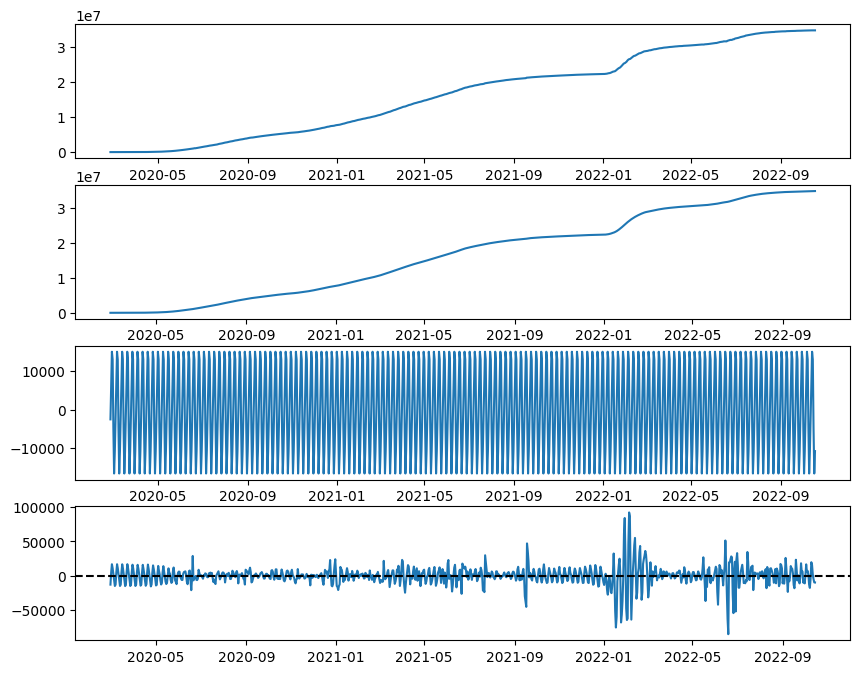

In [72]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.plot(confirmed_cases.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

## Forecasting with Auto-ARIMA (Autoregressive Integrated Moving Average)

In [73]:
forecasting_model = auto_arima(confirmed_cases)

In [74]:
fig = go.Figure(go.Scatter(
    x=confirmed_cases.index, y=confirmed_cases, name='Observed'
))

fig.add_trace(go.Scatter(
    x=confirmed_cases.index, y=forecasting_model.predict_in_sample(), name='Predicted'
))

fig.add_trace(go.Scatter(
    x=pd.date_range('2022-10-18', '2022-11-18'), y=forecasting_model.predict(31), name='Forecasted'
))

fig.update_layout(title='ARIMA Forecasting of COVID-19 Confirmed Cases in Brazil for the Next 30 Days')
fig.show()

## Forecasting com Facebook Prophet

In [75]:
# Preprocessing data

train = confirmed_cases.reset_index()[:-5]
test = confirmed_cases.reset_index()[-5:]

# Rename columns
train.rename(columns={'date':'ds', 'confirmed':'y'}, inplace=True)
test.rename(columns={'date':'ds', 'confirmed':'y'}, inplace=True)

# Define forecasting model
forecast = Prophet(growth='logistic', changepoints=['2020-05-20', '2020-09-20', '2020-12-20', '2021-02-20', '2021-06-30', '2022-01-10', '2022-02-27', '2022-06-20', '2022-08-01'])


pop = 215245031 ## source: https://ibge.gov.br/apps/populacao/projecao/box_popclock.php
train['cap'] = pop

# Train model
forecast.fit(train)

# Forecasting
future_dates = forecast.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast = forecast.predict(future_dates)

21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predicted'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observed - Trained'))
fig.update_layout(title='COVID-19 Confirmed Cases Prediction for Brazil')
fig.show()